In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#default_exp nb_02bis

In [ ]:
#export
from kgl_deepfake.nb_01 import *
from fastai.vision import *
from kgl_deepfake.nb_00 import *
from IPython.display import HTML
import cv2
from tqdm import tqdm
from facenet_pytorch import MTCNN
import time

### Data

In [ ]:
SOURCE = Path('../../data/train_sample_videos/')

In [ ]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T

In [ ]:
sr, sf = annots[annots.label=='REAL'].sample(8), annots[annots.label=='FAKE'].sample(8)
s = sr.append(sf)

In [ ]:
s.head()

label original  split
cfxkpiweqt.mp4  REAL     None  train
bffwsjxghk.mp4  REAL     None  train
bddjdhzfze.mp4  REAL     None  train
dlpoieqvfb.mp4  REAL     None  train
ehccixxzoe.mp4  REAL     None  train

In [ ]:
s['fname'] = pd.Series(s.index).apply(lambda o: SOURCE/o).values
s = s.sample(s.shape[0])

## Test with a Real video

In [ ]:
vid_nbr=1

In [ ]:
s.label[vid_nbr]

'REAL'

In [ ]:
HTML(html_vid(s.fname[vid_nbr]))

In [ ]:
capture = cv2.VideoCapture(str(s.fname[vid_nbr]))

In [ ]:
ret, image = capture.read()

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

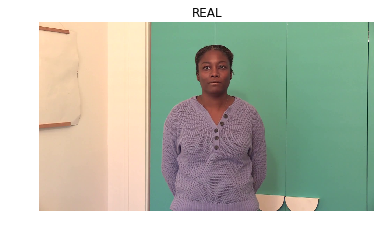

In [ ]:
plt.imshow(image); plt.axis('off'); plt.title(str(s.label[vid_nbr]));

In [ ]:
images_1080_1920 = []
images_720_1280 = []
images_540_960 = []

In [ ]:
%%time
capture = cv2.VideoCapture(str(s.fname[1]))

for i in tqdm(range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))):
    _, image = capture.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_1080_1920.append(image)
    images_720_1280.append(cv2.resize(image, (1280, 720)))
    images_540_960.append(cv2.resize(image, (960, 540)))
capture.release()

images_1080_1920 = np.stack(images_1080_1920)
images_720_1280 = np.stack(images_720_1280)
images_540_960 = np.stack(images_540_960)

print('Shapes:')
print(images_1080_1920.shape)
print(images_720_1280.shape)
print(images_540_960.shape)

100%|██████████| 300/300 [00:02<00:00, 130.65it/s]


Shapes:
(300, 1080, 1920, 3)
(300, 720, 1280, 3)
(300, 540, 960, 3)
CPU times: user 18.1 s, sys: 1.44 s, total: 19.6 s
Wall time: 2.84 s


In [ ]:
def plot_faces(images, figsize=(10.8/2, 19.2/2)):
    shape = images[0].shape
    images = images[np.linspace(0, len(images)-1, 16).astype(int)]
    im_plot = []
    for i in range(0, 16, 4):
        im_plot.append(np.concatenate(images[i:i+4], axis=0))
    im_plot = np.concatenate(im_plot, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(im_plot)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax.grid(False)
    fig.tight_layout()

def timer(detector, detect_fn, images, *args):
    start = time.time()
    faces = detect_fn(detector, images, *args)
    elapsed = time.time() - start
    print(f', {elapsed:.3f} seconds')
    return faces, elapsed

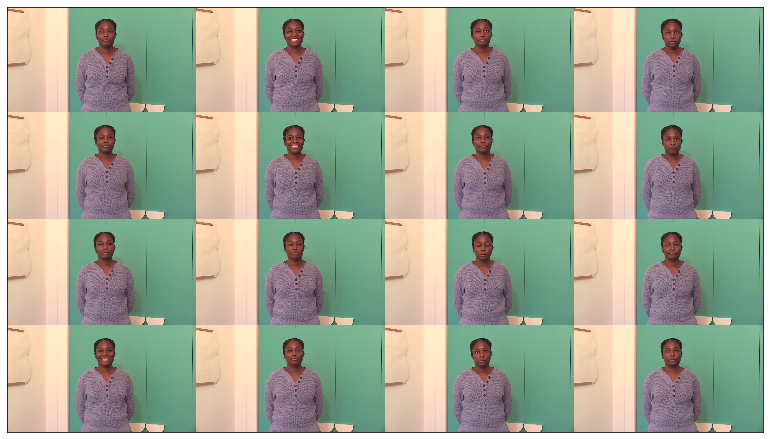

In [ ]:
plot_faces(images_540_960, figsize=(10.8, 19.2))

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return faces

times_facenet_pytorch = []

In [ ]:
images_540_960.shape

(300, 540, 960, 3)

In [ ]:
from PIL import Image

In [ ]:
%%time
faces = detect_facenet_pytorch(detector, images_540_960, 32)

CPU times: user 3.3 s, sys: 237 ms, total: 3.54 s
Wall time: 2.93 s


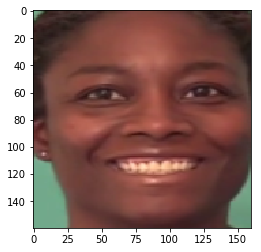

In [ ]:
plt.imshow(faces[100].permute(1, 2, 0)/255.)

In [ ]:
diff = [abs(faces[i] - faces[i-1]) for i in range(len(faces))]

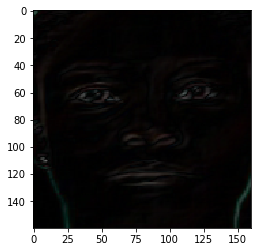

In [ ]:
plt.imshow(diff[3].permute(1, 2, 0)/255.)

In [ ]:
idxs = list(range(100,130))

In [ ]:
#export
def show_faces(faces, idxs):
    ncols = 4
    nrows = int((len(idxs) - 1) / ncols) + 1
    _, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 4*nrows))
    for idx, ax in itertools.zip_longest(idxs, axs.flatten()):
        if idx:
            #img = np.array(faces[idx])
            ax.imshow(diff[idx].permute(1, 2, 0)/255.); ax.set_title(idx)
        ax.axis('off')

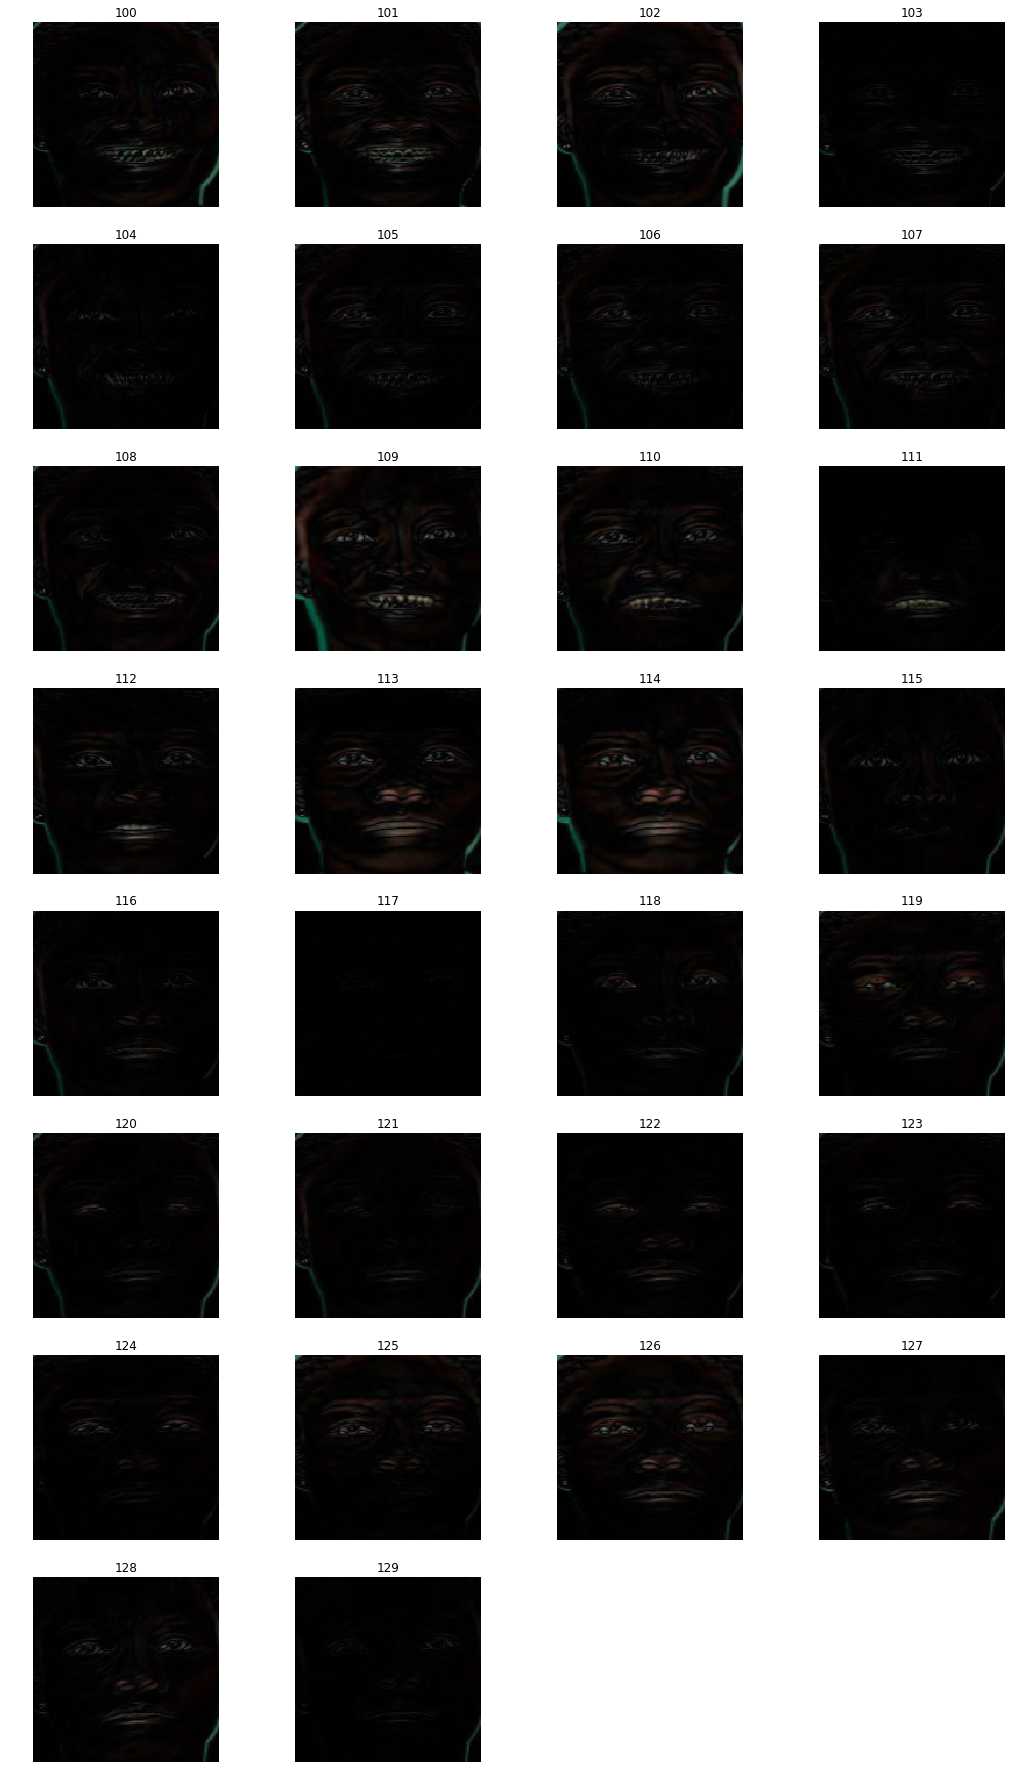

In [ ]:
show_faces(diff, idxs)

## Test with a Fake Video

In [ ]:
vid_nbr = 7

In [ ]:
s.label[vid_nbr]

'FAKE'

In [ ]:
HTML(html_vid(s.fname[vid_nbr]))

In [ ]:
capture = cv2.VideoCapture(str(s.fname[vid_nbr]))

In [ ]:
ret, image = capture.read()

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

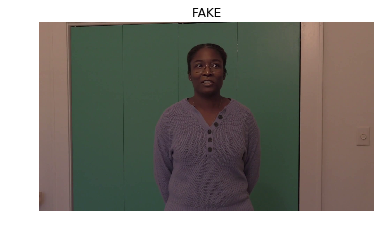

In [ ]:
plt.imshow(image); plt.axis('off'); plt.title(str(s.label[vid_nbr]));

In [ ]:
images_1080_1920 = []
images_720_1280 = []
images_540_960 = []

In [ ]:
%%time
capture = cv2.VideoCapture(str(s.fname[vid_nbr]))

for i in tqdm(range(int(capture.get(cv2.CAP_PROP_FRAME_COUNT)))):
    _, image = capture.read()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_1080_1920.append(image)
    images_720_1280.append(cv2.resize(image, (1280, 720)))
    images_540_960.append(cv2.resize(image, (960, 540)))
capture.release()

images_1080_1920 = np.stack(images_1080_1920)
images_720_1280 = np.stack(images_720_1280)
images_540_960 = np.stack(images_540_960)

print('Shapes:')
print(images_1080_1920.shape)
print(images_720_1280.shape)
print(images_540_960.shape)

100%|██████████| 300/300 [00:02<00:00, 133.72it/s]


Shapes:
(300, 1080, 1920, 3)
(300, 720, 1280, 3)
(300, 540, 960, 3)
CPU times: user 17.6 s, sys: 1.6 s, total: 19.2 s
Wall time: 2.76 s


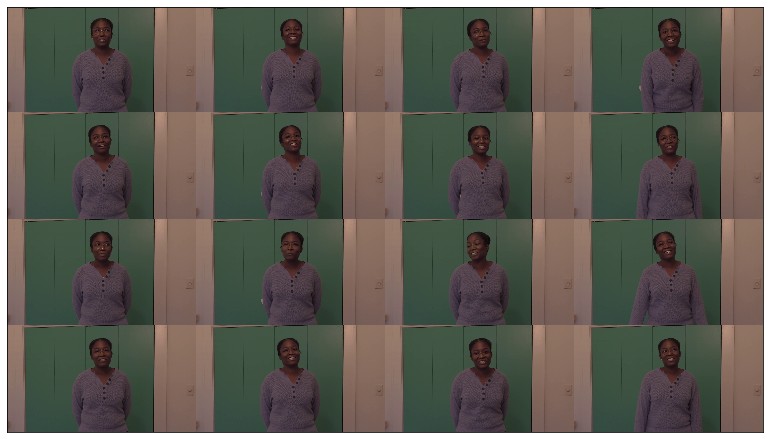

In [ ]:
plot_faces(images_540_960, figsize=(10.8, 19.2))

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

def detect_facenet_pytorch(detector, images, batch_size):
    faces = []
    for lb in np.arange(0, len(images), batch_size):
        imgs_pil = [Image.fromarray(image) for image in images[lb:lb+batch_size]]
        faces.extend(detector(imgs_pil))
    return faces

times_facenet_pytorch = []

In [ ]:
images_540_960.shape

(300, 540, 960, 3)

In [ ]:
from PIL import Image

In [ ]:
%%time
faces = detect_facenet_pytorch(detector, images_540_960, 32)

CPU times: user 2.55 s, sys: 361 ms, total: 2.91 s
Wall time: 2.93 s


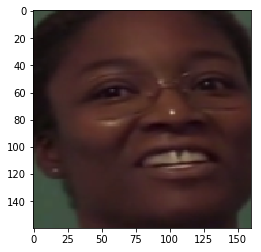

In [ ]:
plt.imshow(faces[100].permute(1, 2, 0)/255.)

In [ ]:
# I don't know why I get an error here
diff = [abs(faces[i] - faces[i-1]) for i in range(len(faces))]

In [ ]:
idxs = list(range(100,130))

In [ ]:
#export
def plot_faces(faces, idxs):
    ncols = 4
    nrows = int((len(idxs) - 1) / ncols) + 1
    _, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(18, 4*nrows))
    for idx, ax in itertools.zip_longest(idxs, axs.flatten()):
        if idx:
            #img = np.array(faces[idx])
            ax.imshow(diff[idx].permute(1, 2, 0)/255.); ax.set_title(idx)
        ax.axis('off')

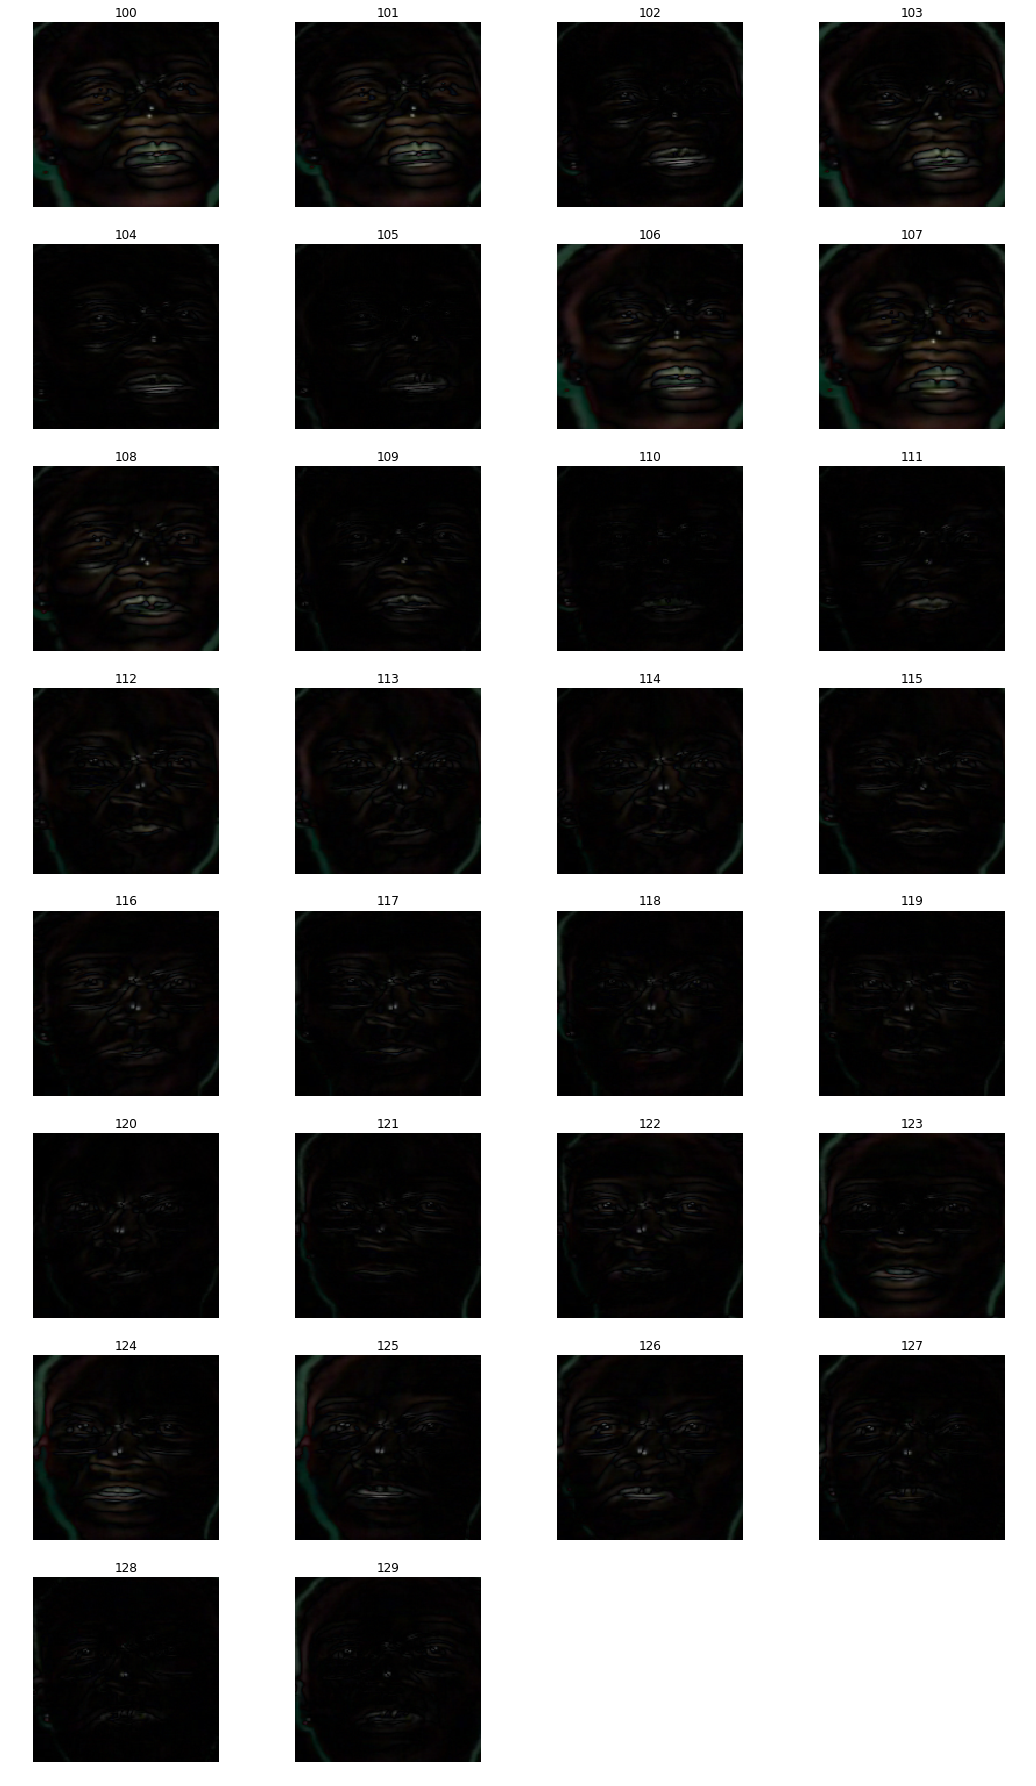

In [ ]:
plot_faces(diff, idxs)

# Pipeline

In [ ]:
#export

#comes from https://www.kaggle.com/unkownhihi/starter-kernel-with-cnn-model-ll-lb-0-69235
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""
    
    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.
        
        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize
    
    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
detector = MTCNN(device=device, post_process=False)

In [ ]:
from PIL import Image #Otherwise it uses fastai's Image, which creates errors

In [ ]:
# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=detector, n_frames=5, batch_size=60, resize=0.25)

In [ ]:
# Get all test videos
filenames = glob.glob('../../data/test_videos/*.mp4')

In [ ]:
len(filenames)

400

In [ ]:
faces = detection_pipeline(filenames[1])

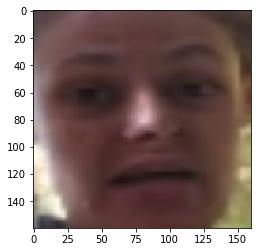

In [ ]:
plt.imshow(faces[0].permute(1,2,0)/255.)

In [ ]:
sample_filenames = filenames[:10]

In [ ]:
X = []
start = time.time()
n_processed = 0
with torch.no_grad():
    for i, filename in tqdm(enumerate(sample_filenames), total=len(sample_filenames)):
        try:
            # Load frames and find faces
            faces = detection_pipeline(filename)
            
            # Calculate embeddings
            X.append(faces)

        except KeyboardInterrupt:
            print('\nStopped.')
            break

        except Exception as e:
            print(e)
            X.append(None)
        
        n_processed += len(faces)
        print(f'Frames per second (load+detect+embed): {n_processed / (time.time() - start):6.3}\r', end='')

 10%|█         | 1/10 [00:00<00:05,  1.72it/s]

 20%|██        | 2/10 [00:01<00:04,  1.65it/s]

 30%|███       | 3/10 [00:01<00:04,  1.67it/s]

 40%|████      | 4/10 [00:02<00:03,  1.74it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

 70%|███████   | 7/10 [00:04<00:01,  1.79it/s]

 80%|████████  | 8/10 [00:04<00:01,  1.77it/s]

 90%|█████████ | 9/10 [00:05<00:00,  1.84it/s]

100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

In [ ]:
def show_images(images, cols = 2):
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image is not None: plt.imshow(image.permute(1, 2, 0)/255.)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

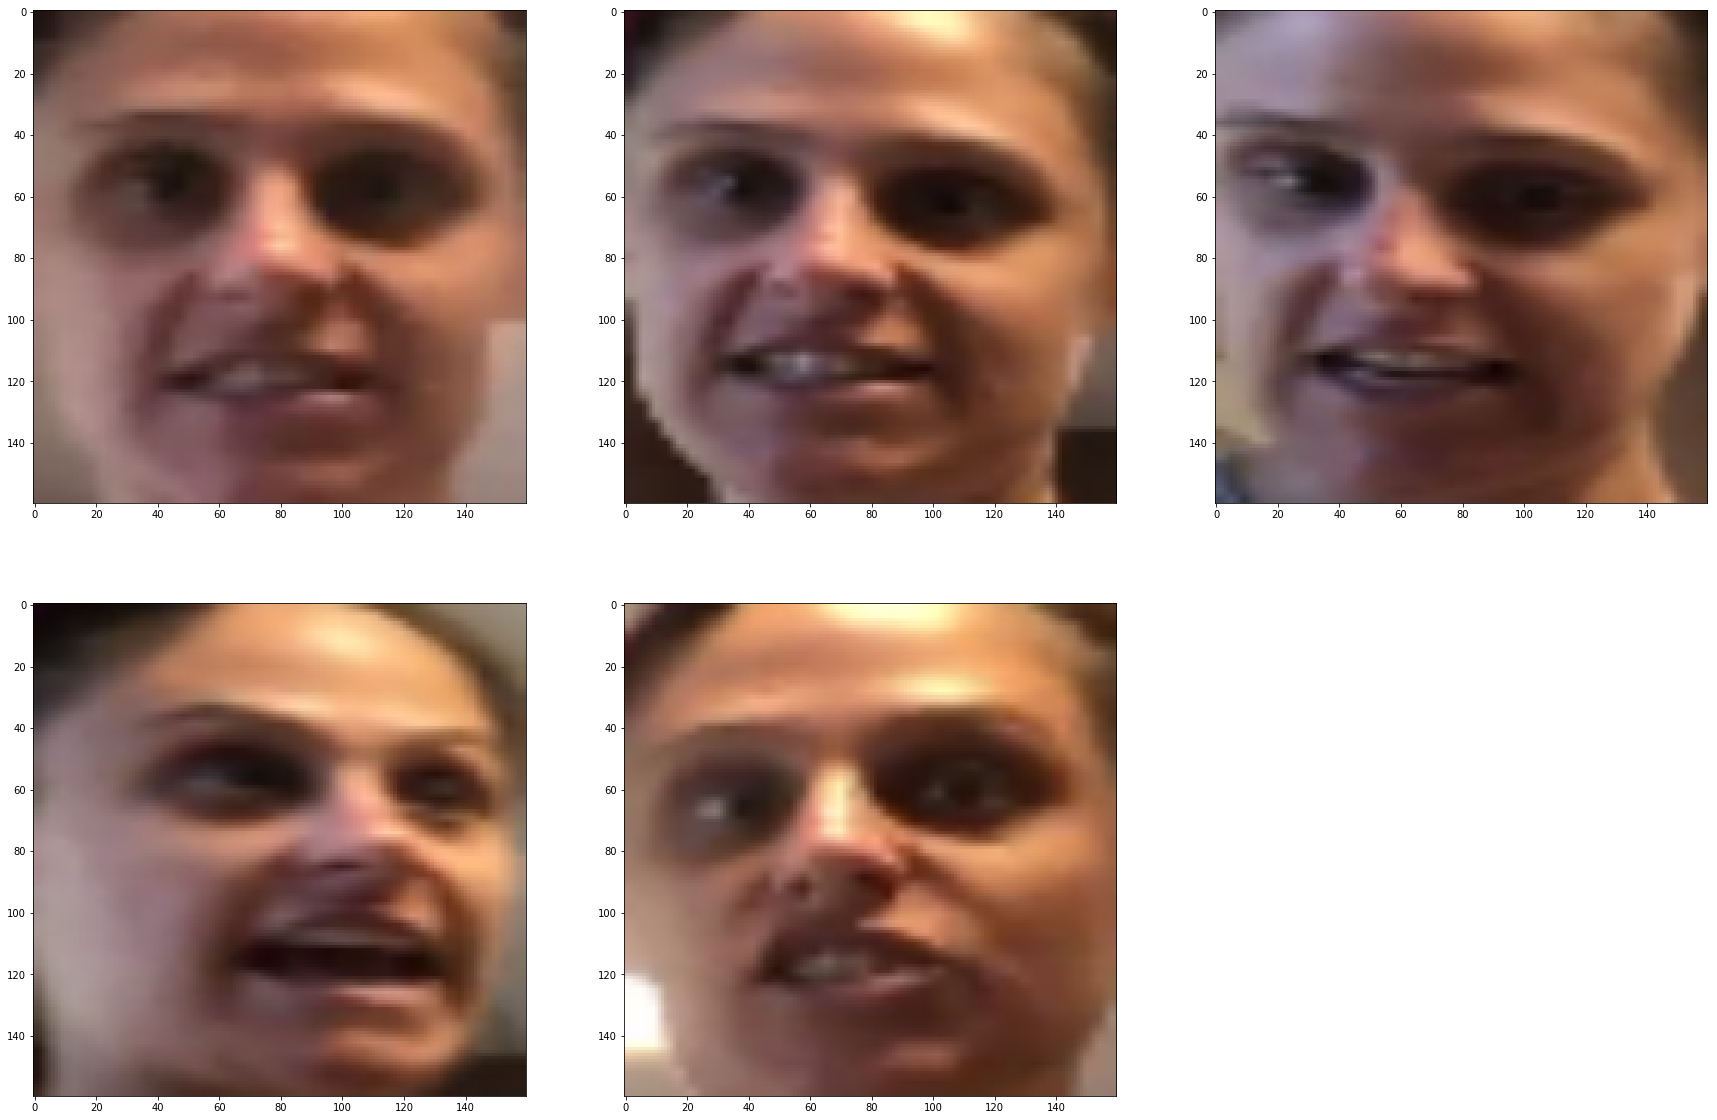

In [ ]:
show_images(X[0])

# - fin

In [ ]:
from nbdev.export import *

In [ ]:
notebook2script()

Converted 00_lookatdata.ipynb.
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
Converted 01_face_recog.ipynb.
Converted 01a_face_extraction.ipynb.
Converted 02_face_extraction.ipynb.
Converted 02bis_Create_Dataset-Copy1.ipynb.
Converted 02bis_Create_Dataset.ipynb.
Converted 03_mesonet.ipynb.
